# Bot classifier

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
from sklearn import model_selection, linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

import missingno as msno

In [3]:
full = pd.read_csv('data/bot_or_not/train.csv')

In [4]:
full.columns

Index(['avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'contributors_enabled',
       'created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'follow_request_sent', 'followers_count',
       'following', 'freq', 'friends_count', 'geo_enabled', 'is_translator',
       'lang', 'listed_count', 'location', 'max_fav', 'max_hash', 'max_len',
       'max_ret', 'media_perc', 'min_fav', 'min_hash', 'min_len', 'min_ret',
       'name', 'notifications', 'profile_background_color',
       'profile_background_image_url', 'profile_background_image_url_https',
       'profile_background_tile', 'profile_image_url',
       'profile_image_url_https', 'profile_link_color',
       'profile_sidebar_border_color', 'profile_sidebar_fill_color',
       'profile_text_color', 'profile_use_background_image', 'protected',
       'quote_perc', 'ret_perc', 'screen_name', 'statuses_count', 'target',
       'time_zone', 'tweet_intradistance', 'url', 'url_intradistance',
      

## Data exploration

In [5]:
full.describe()

,avg_fav,avg_hash,avg_len,avg_ret,favourites_count,followers_count,freq,friends_count,listed_count,max_fav,...,min_hash,min_len,min_ret,quote_perc,ret_perc,target,tweet_intradistance,url_intradistance,url_perc,utc_offset
count,15455.000000,15455.000000,15455.000000,15455.000000,15452.000000,1.545500e+04,15455.000000,1.545200e+04,15452.000000,15455.000000,...,15455.000000,15455.000000,15455.000000,15455.000000,15455.000000,15449.000000,15455.000000,15455.000000,15455.000000,1727.000000
mean,3.097362,0.341198,81.059805,1640.245521,3825.046596,1.888063e+04,4.144654,3.594335e+03,174.087108,82.717114,...,2.658234,22.498350,6.152572,0.041623,0.178269,0.504175,10.358458,4.148089,0.313607,-4839.258830
std,59.237195,0.738631,44.619469,6054.541872,17167.937826,6.440631e+05,11.945211,2.891204e+04,1311.388046,2652.209490,...,3.149491,23.675631,434.279664,0.080563,0.266270,0.499999,4.774776,3.448895,0.350897,22380.037587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-39600.000000
25%,0.010000,0.000000,64.105000,0.020000,2.000000,1.680000e+02,0.063291,1.950000e+02,2.000000,1.000000,...,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,10.412994,0.000000,0.000000,-25200.000000
50%,0.112500,0.100000,87.210000,1.420000,126.500000,7.410000e+02,0.312500,5.580000e+02,16.000000,3.000000,...,2.000000,18.000000,0.000000,0.000000,0.030000,1.000000,11.846343,3.789063,0.163265,-14400.000000
75%,0.500000,0.363636,108.186774,534.690000,1466.000000,3.265500e+03,2.152174,1.759000e+03,81.250000,8.000000,...,4.000000,29.000000,0.000000,0.050000,0.260870,1.000000,13.062085,7.078027,0.540000,18000.000000
max,3372.340000,20.000000,299.180000,294528.510000,543756.000000,7.636714e+07,100.000000,3.003918e+06,107815.000000,234334.000000,...,88.000000,279.000000,49064.000000,1.000000,1.000000,1.000000,24.269322,9.899020,1.000000,46800.000000


Delete naive features 

In [6]:
full = full.drop(columns=['contributors_enabled', 'follow_request_sent', 'following', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_image_url', 'profile_image_url_https', 'time_zone', 'utc_offset'])

plot missing values

In [7]:
features = full.columns

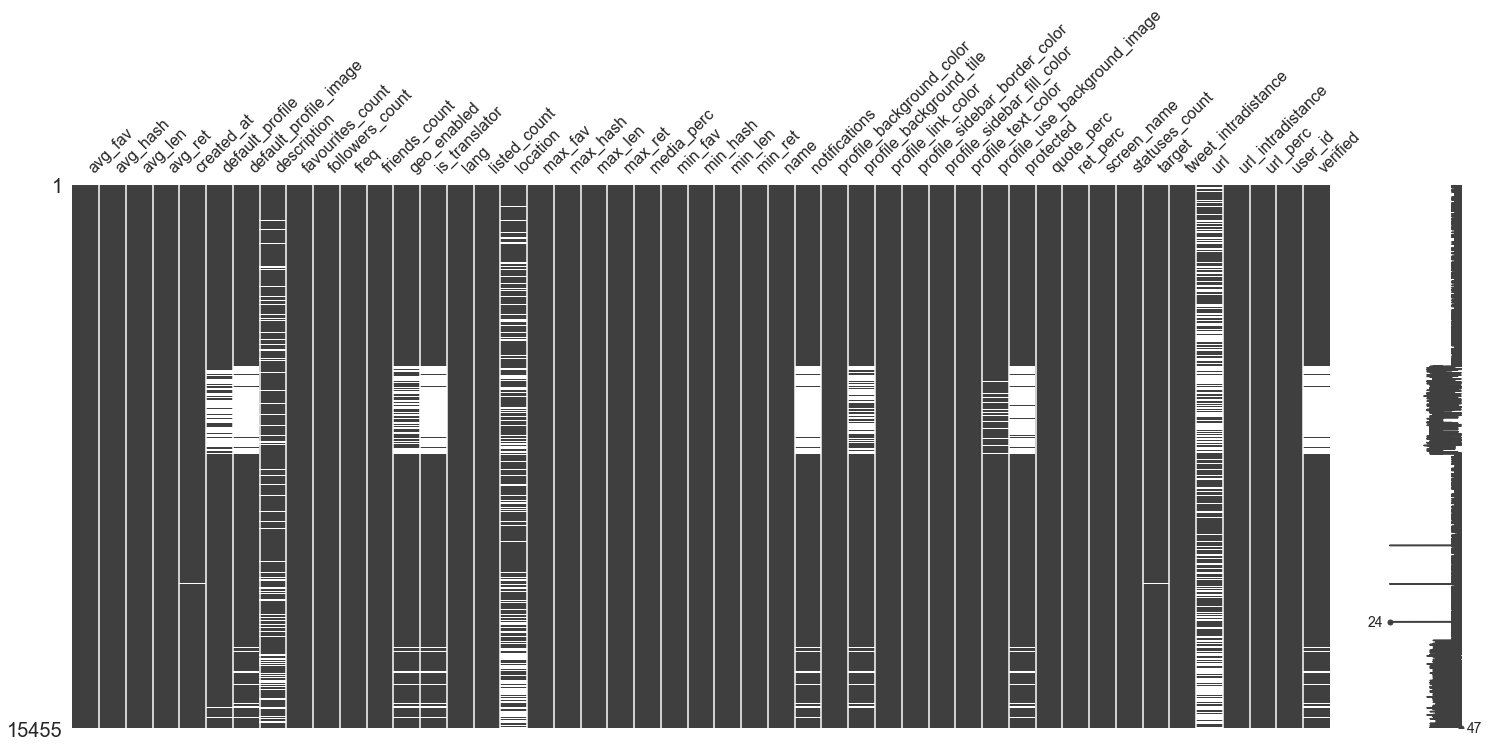

In [8]:
msno.matrix(full)

plot missing values for each target

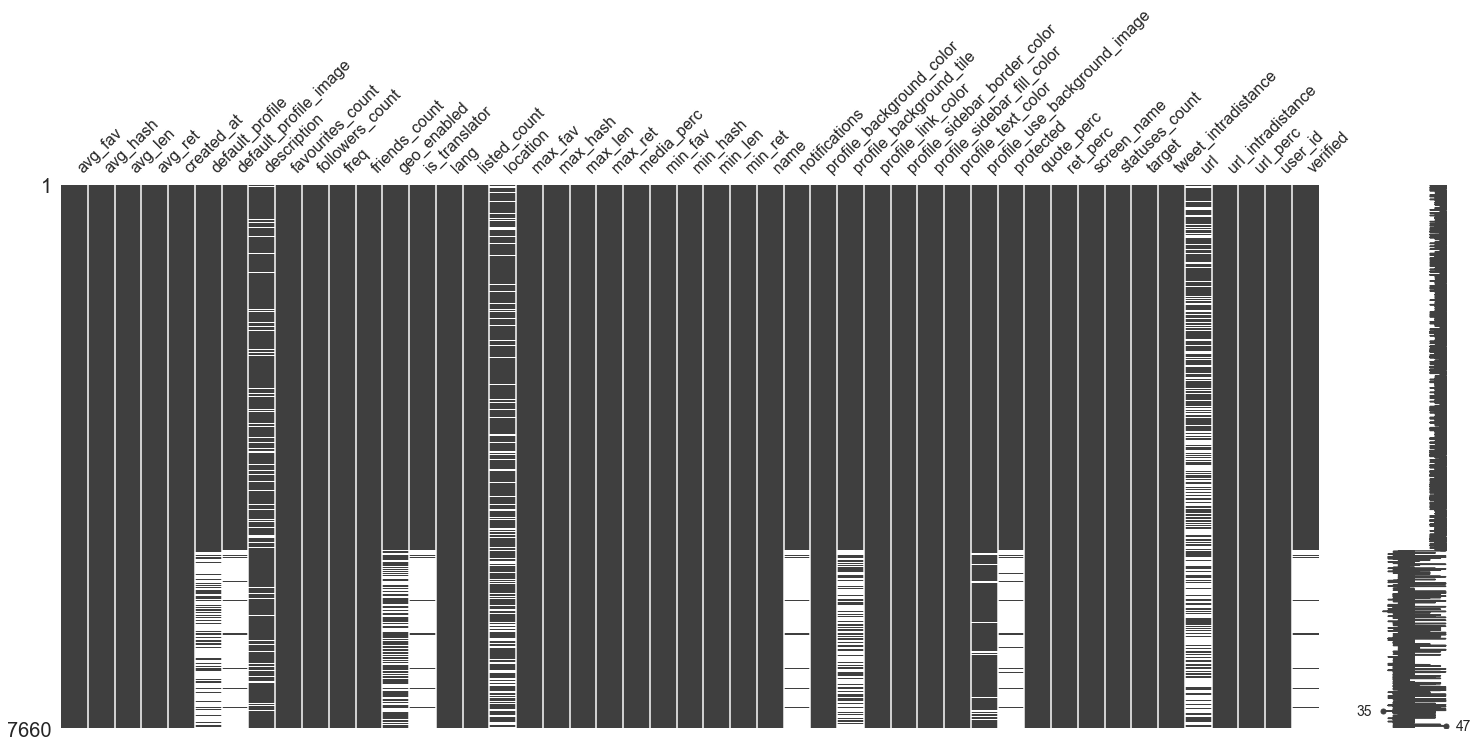

In [9]:
msno.matrix(full[full.target==0])

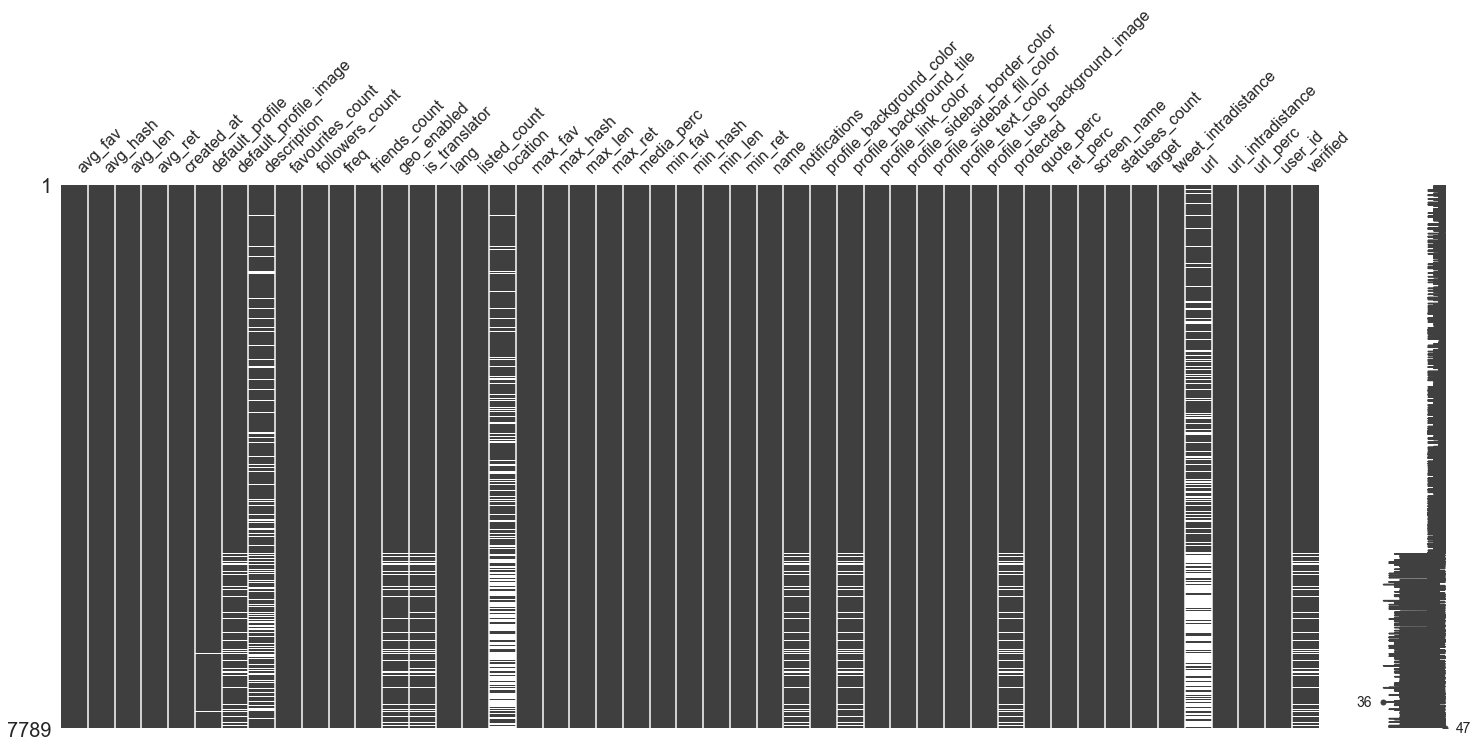

In [10]:
msno.matrix(full[full.target==1])

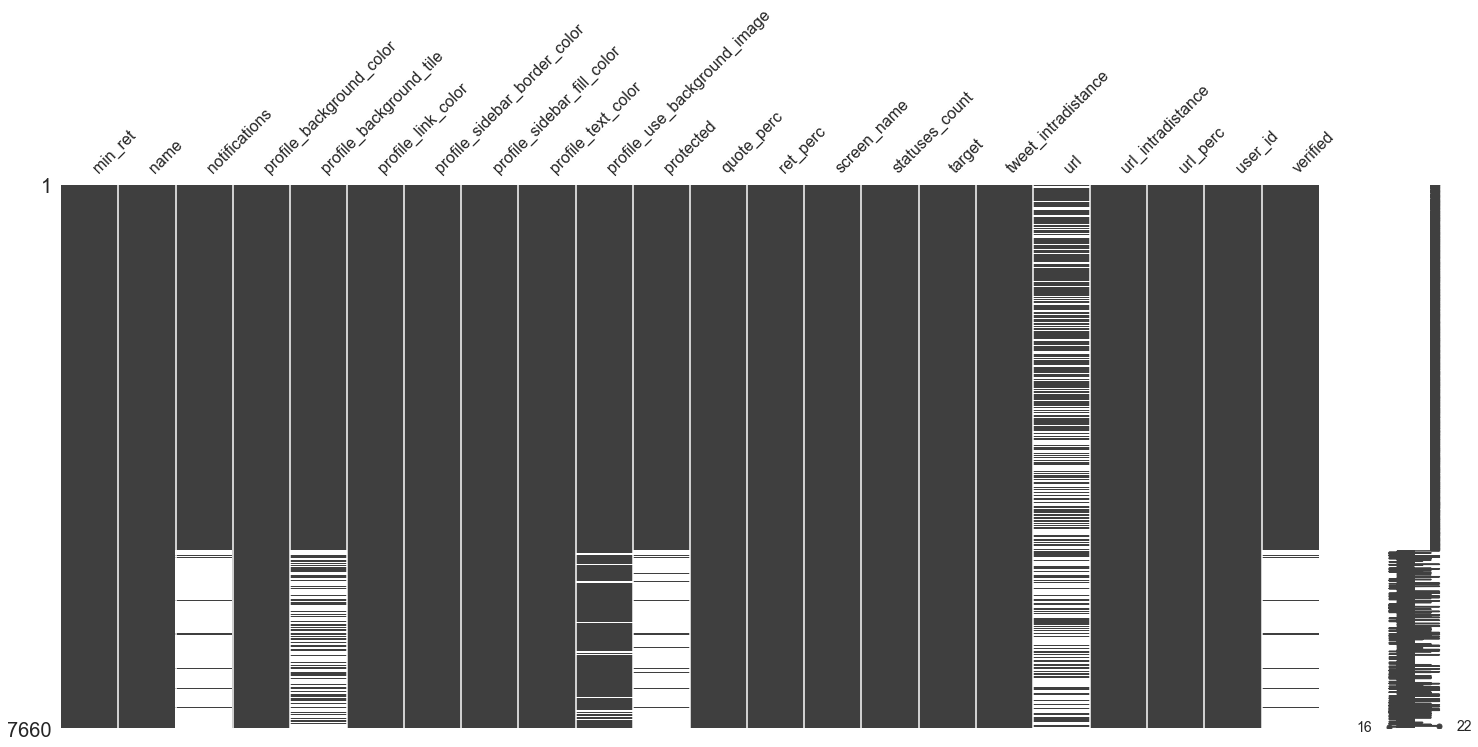

In [11]:
msno.matrix(full[full.target==0][features[25:]])

Remove features with too many missing values for some target

In [12]:
full = full.drop(columns=['default_profile_image','is_translator', 'geo_enabled', 'location', 'notifications', 'profile_background_tile', 'protected', 'verified'])

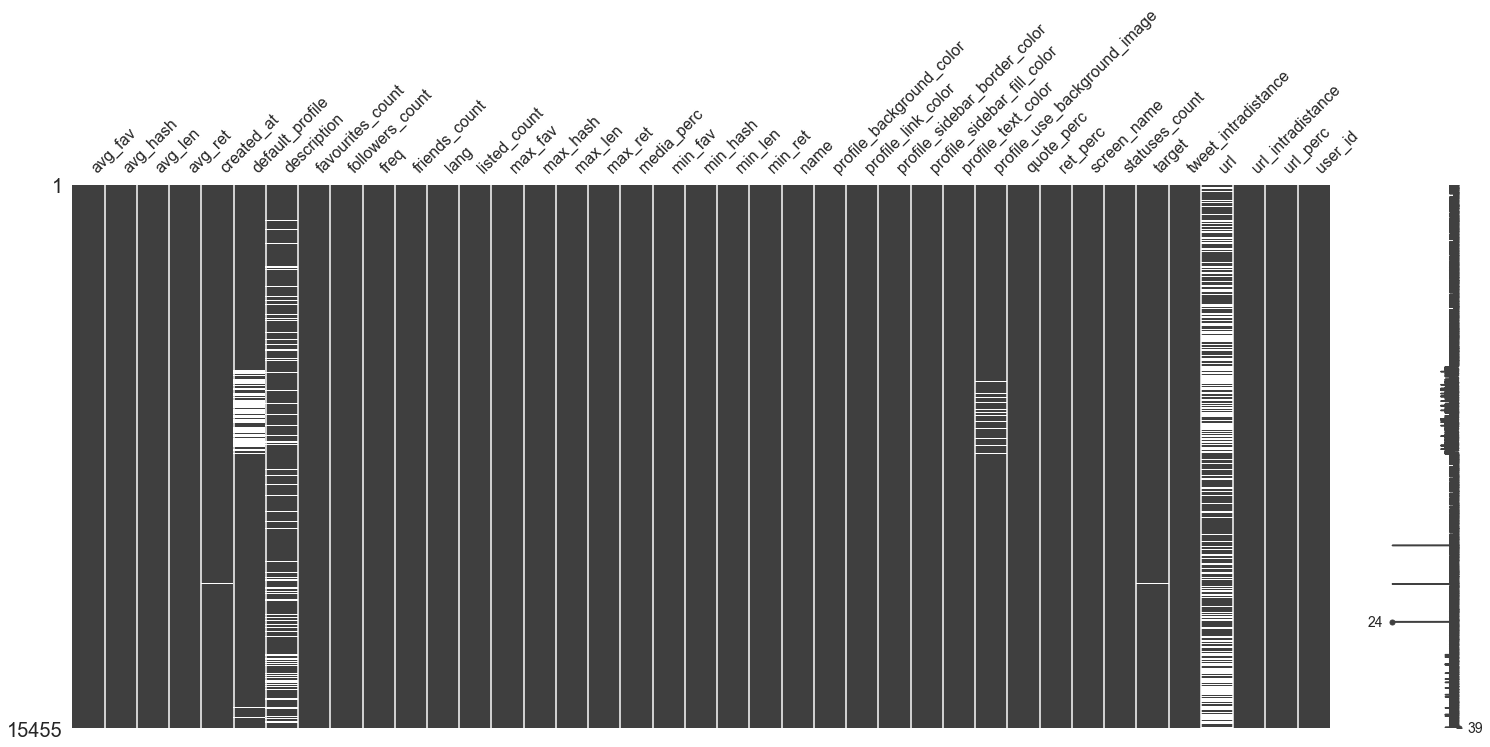

In [13]:
msno.matrix(full)

In [14]:
full.default_profile.describe()

count     13743
unique        4
top         0.0
freq       5577
Name: default_profile, dtype: object

In [17]:
full[full.target==0].default_profile.describe()

count     5982
unique       2
top        0.0
freq      4842
Name: default_profile, dtype: object

In [18]:
full[full.target==1].default_profile.describe()

count      7758
unique        4
top       False
freq       4657
Name: default_profile, dtype: object

In [19]:
full['default_profile'] = full['default_profile'].fillna(full['default_profile'].mode()[0])

In [20]:
full['description'] = full['description'].fillna('')

In [21]:
full['description_len'] = full['description'].apply(lambda x: len(x))

In [22]:
full = full.drop(columns=['description'])

In [23]:
full['name'] = full['name'].fillna('')

In [24]:
full['name_len'] = full['name'].apply(lambda x: len(x))

In [25]:
full = full.drop(columns=['name'])

In [26]:
full['screen_name'] = full['screen_name'].fillna('')

In [27]:
full['screen_name_len'] = full['screen_name'].apply(lambda x: len(x))

In [28]:
full = full.drop(columns=['screen_name'])

In [29]:
full = full.drop(columns=['lang'])

In [30]:
def oldness(x):
    if x[0] == '2':
        return 2018 - int(x[:4])
    else:
        return 2018 - int(x[-4:])

In [39]:
types = []
for elem in full['created_at']:
    types.append(type(elem))
set(types)

{float, str}

In [42]:
mask = full['created_at'].isnull()

In [45]:
full.drop(full.index[mask], inplace=True)

In [46]:
full['age'] = full['created_at'].apply(lambda x: oldness(x))

In [47]:
full = full.drop(columns=['created_at'])

In [34]:
# full = full.drop(columns=['user_id'])

In [48]:
full['profile_use_background_image'][full.target==0].value_counts()

1.0    6568
0.0     825
Name: profile_use_background_image, dtype: int64

In [49]:
full['profile_use_background_image'][full.target==1].value_counts()

True     4775
1.0      2409
False     514
0.0        91
Name: profile_use_background_image, dtype: int64

In [51]:
full['profile_use_background_image'] = (full['profile_use_background_image'].notnull()).astype(int)

In [50]:
full['profile_use_background_image'] = full['profile_use_background_image'].fillna(full['profile_use_background_image'].mode()[0])

In [52]:
full['url'] = (full['url'].notnull()).astype(int)

verifico che non ci siano più missing values

In [53]:
full.isnull().astype(int).sum()

avg_fav                         0
avg_hash                        0
avg_len                         0
avg_ret                         0
default_profile                 0
favourites_count                0
followers_count                 0
freq                            0
friends_count                   0
listed_count                    0
max_fav                         0
max_hash                        0
max_len                         0
max_ret                         0
media_perc                      0
min_fav                         0
min_hash                        0
min_len                         0
min_ret                         0
profile_background_color        0
profile_link_color              0
profile_sidebar_border_color    0
profile_sidebar_fill_color      0
profile_text_color              0
profile_use_background_image    0
quote_perc                      0
ret_perc                        0
statuses_count                  0
target                          0
tweet_intradis

In [61]:
full.drop(columns=['profile_background_color', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color','profile_text_color'], inplace=True)      

In [65]:
full.describe()

,avg_fav,avg_hash,avg_len,avg_ret,favourites_count,followers_count,freq,friends_count,listed_count,max_fav,...,ret_perc,target,tweet_intradistance,url,url_intradistance,url_perc,description_len,name_len,screen_name_len,age
count,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,1.544900e+04,15449.000000,1.544900e+04,15449.000000,15449.000000,...,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000,15449.000000
mean,3.098546,0.341257,81.075206,1637.531247,3825.529549,1.888786e+04,4.145435,3.594986e+03,174.119360,82.748657,...,0.178242,0.504175,10.360155,0.573047,4.149138,0.313711,72.527736,11.699463,10.653117,8.178911
std,59.248667,0.738731,44.613789,6048.715193,17169.563838,6.441881e+05,11.947256,2.891481e+04,1311.513331,2652.724015,...,0.266265,0.499999,4.773460,0.494651,3.449020,0.350924,53.455676,4.684419,2.785371,2.410402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,0.010000,0.000000,64.130000,0.020000,2.000000,1.680000e+02,0.063291,1.950000e+02,2.000000,1.000000,...,0.000000,0.000000,10.413269,0.000000,0.000000,0.000000,25.000000,9.000000,9.000000,7.000000
50%,0.113402,0.100000,87.214286,1.420000,126.000000,7.420000e+02,0.312500,5.580000e+02,16.000000,3.000000,...,0.030000,1.000000,11.846502,1.000000,3.789268,0.163265,66.000000,12.000000,11.000000,9.000000
75%,0.500000,0.363636,108.200000,534.470000,1466.000000,3.266000e+03,2.152174,1.759000e+03,82.000000,8.000000,...,0.260417,1.000000,13.062755,1.000000,7.079361,0.540000,121.000000,14.000000,13.000000,10.000000
max,3372.340000,20.000000,299.180000,294528.510000,543756.000000,7.636714e+07,100.000000,3.003918e+06,107815.000000,234334.000000,...,1.000000,1.000000,24.269322,1.000000,9.899020,1.000000,191.000000,50.000000,15.000000,12.000000


In [67]:
full['default_profile'] = (full['default_profile'].notnull()).astype(int)
full['statuses_count'] = (full['statuses_count'].notnull()).astype(int)
full['user_id'] = (full['user_id'].notnull()).astype(int)

In [69]:
full.to_csv('data/bot_or_not/full_preproc_train.csv')

# riparti da qui per evitare preprocessing

In [44]:
full = pd.read_csv('data/bot_or_not/full_preproc_train.csv')

In [73]:
def predict(X, y, n_trees=5, max_depth=None, knn=10):
    
    forest = RandomForestClassifier(n_estimators = n_trees, max_depth=max_depth, criterion = 'entropy', random_state = 42)
    logreg = linear_model.LogisticRegression()
    
    scaler = MinMaxScaler()
    X_n = scaler.fit_transform(X)
    knn = KNeighborsClassifier(n_neighbors=knn)
    scoring = ['f1', 'precision', 'recall', 'roc_auc']
    scores = []
    scores.append(cross_validate(forest, X, y, cv=10, scoring=scoring))
    scores.append(cross_validate(logreg, X, y, cv=10, scoring=scoring))
    scores.append(cross_validate(knn, X_n, y, cv=10, scoring=scoring))
    
    return scores

In [224]:
# split X,y
X = full.drop(columns=['target', 'user_id'])
y = full['target']

In [225]:
baselines = predict(X,y)

## RF scores:

In [226]:
print("F1:")
print(baselines[0]['test_f1'].mean())
print("Precision:")
print(baselines[0]['test_precision'].mean())
print("Recall:")
print(baselines[0]['test_recall'].mean())
print("AUC:")
print(baselines[0]['test_roc_auc'].mean())

F1:
0.8163418051908445
Precision:
0.8423100006518018
Recall:
0.8078211470113619
AUC:
0.8932364724458001


## LogReg Scores:

In [227]:
print("F1:")
print(baselines[1]['test_f1'].mean())
print("Precision:")
print(baselines[1]['test_precision'].mean())
print("Recall:")
print(baselines[1]['test_recall'].mean())
print("AUC:")
print(baselines[1]['test_roc_auc'].mean())

F1:
0.7178397006842985
Precision:
0.6947758364937806
Recall:
0.7477053502776945
AUC:
0.7880874265438276


## KNN scores:

In [228]:
print("F1:")
print(baselines[2]['test_f1'].mean())
print("Precision:")
print(baselines[2]['test_precision'].mean())
print("Recall:")
print(baselines[2]['test_recall'].mean())
print("AUC:")
print(baselines[2]['test_roc_auc'].mean())

F1:
0.7606496400243804
Precision:
0.7791158731288068
Recall:
0.7501740745996284
AUC:
0.8351536218196463


# Grid Search

In [229]:
def grid_search(X, y, model, params):
    
    scoring = ['f1', 'precision', 'recall', 'roc_auc']
    grid = GridSearchCV(model, params, cv=10, scoring=scoring, refit='f1')
    grid.fit(X, y)
    
    return grid

### Random Forest

In [230]:
params = {'n_estimators':[10,15,20,25,30,35,40,45], 'max_depth':[20, 22, 24, 26, 28, 30], 'criterion': ['gini', 'entropy']}
model = RandomForestClassifier()

rf_grid = grid_search(X, y, model, params)

In [231]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [232]:
results = pd.DataFrame(rf_grid.cv_results_)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_f1'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_f1'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6

In [233]:
best_scores = sorted(results.mean_test_f1)[-10:]

In [234]:
mask = np.in1d(results.mean_test_f1,best_scores)

In [235]:
best_grid = results.iloc[mask]

In [240]:
best_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_f1,split1_test_f1,...,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,split5_train_roc_auc,split6_train_roc_auc,split7_train_roc_auc,split8_train_roc_auc,split9_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
23,1.363673,0.027862,0.074795,0.007471,gini,24,45,"{'criterion': 'gini', 'max_depth': 24, 'n_esti...",0.679339,0.865258,...,0.999999,1.000000,0.999998,1.000000,1.000000,1.000000,0.999999,0.999998,0.999999,9.150950e-07
29,1.316346,0.423606,0.068066,0.013157,gini,26,35,"{'criterion': 'gini', 'max_depth': 26, 'n_esti...",0.679901,0.851064,...,0.999999,0.999998,0.999998,0.999999,0.999997,0.999999,0.999998,0.999999,0.999998,8.086744e-07
45,1.214687,0.063775,0.069229,0.010383,gini,30,35,"{'criterion': 'gini', 'max_depth': 30, 'n_esti...",0.678838,0.846871,...,0.999995,0.999999,0.999999,0.999996,0.999999,1.000000,0.999996,1.000000,0.999998,1.590987e-06
47,1.501405,0.077418,0.081796,0.004850,gini,30,45,"{'criterion': 'gini', 'max_depth': 30, 'n_esti...",0.679370,0.857143,...,0.999997,0.999999,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.999999,7.970482e-07
53,1.482709,0.057559,0.058270,0.005185,entropy,20,35,"{'criterion': 'entropy', 'max_depth': 20, 'n_e...",0.666667,0.859051,...,0.999985,0.999988,0.999997,0.999995,0.999994,0.999995,0.999982,0.999983,0.999990,5.130858e-06
55,1.827249,0.036200,0.072582,0.005416,entropy,20,45,"{'criterion': 'entropy', 'max_depth': 20, 'n_e...",0.671692,0.847957,...,0.999993,0.999990,0.999996,0.999997,0.999996,0.999995,0.999994,0.999995,0.999995,2.068954e-06
61,1.593412,0.067955,0.064689,0.004942,entropy,22,35,"{'criterion': 'entropy', 'max_depth': 22, 'n_e...",0.669442,0.864757,...,0.999999,0.999992,0.999999,0.999994,0.999995,0.999989,0.999996,0.999999,0.999995,3.352805e-06
62,1.874130,0.166505,0.079559,0.016348,entropy,22,40,"{'criterion': 'entropy', 'max_depth': 22, 'n_e...",0.684864,0.853872,...,0.999999,0.999997,1.000000,0.999998,0.999999,0.999999,0.999999,0.999994,0.999998,1.682108e-06
71,2.242992,0.194186,0.085562,0.012903,entropy,24,45,"{'criterion': 'entropy', 'max_depth': 24, 'n_e...",0.672773,0.857713,...,1.000000,0.999999,1.000000,0.999999,1.000000,0.999999,1.000000,1.000000,1.000000,5.255443e-07
79,2.813693,0.377745,0.113519,0.014442,entropy,26,45,"{'criterion': 'entropy', 'max_depth': 26, 'n_e...",0.682081,0.861930,...,1.000000,0.999999,0.999999,1.000000,1.000000,1.000000,0.999999,0.999998,0.999999,5.399826e-07


In [198]:
best_grid.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_n_estimators', 'params',
       'split0_test_f1', 'split1_test_f1',
       ...
       'split2_train_roc_auc', 'split3_train_roc_auc', 'split4_train_roc_auc',
       'split5_train_roc_auc', 'split6_train_roc_auc', 'split7_train_roc_auc',
       'split8_train_roc_auc', 'split9_train_roc_auc', 'mean_train_roc_auc',
       'std_train_roc_auc'],
      dtype='object', length=108)

## Visualize Results

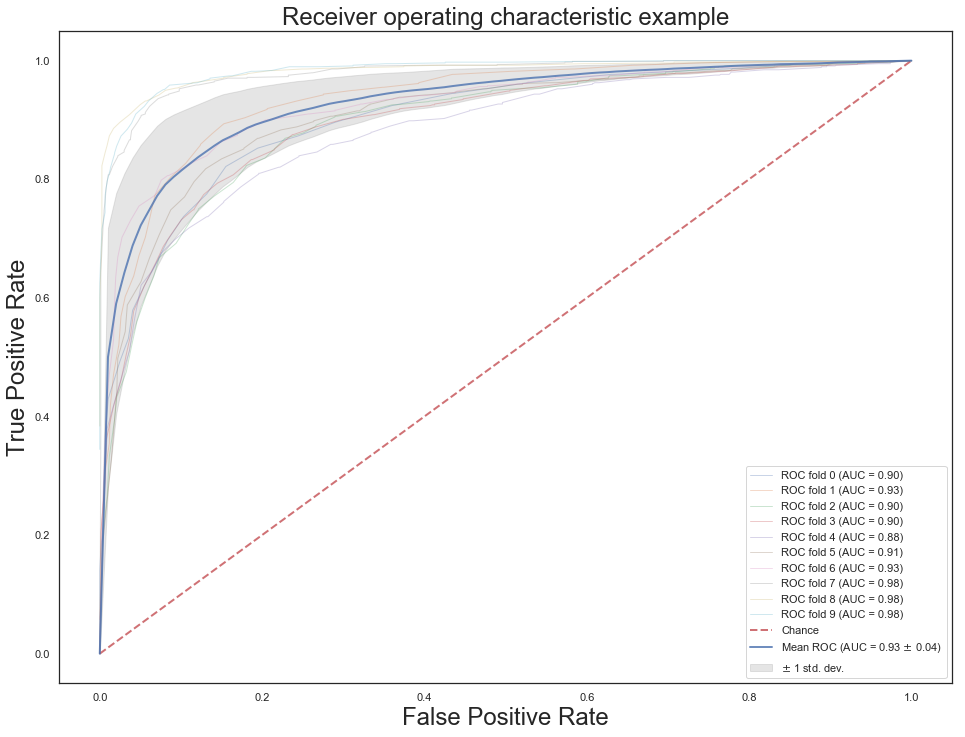

In [241]:
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = RandomForestClassifier(n_estimators=35, criterion='gini', max_depth=26)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(16,12))

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('data/bot_or_not/auc.png')
plt.show()

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


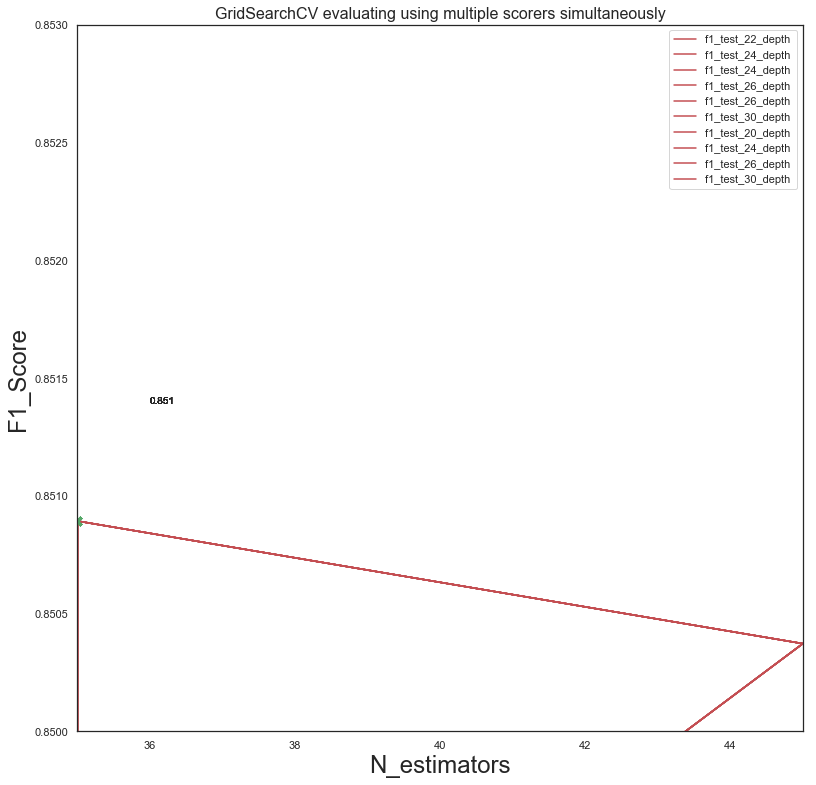

In [194]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("N_estimators")
plt.ylabel("F1_Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(35, 45)
ax.set_ylim(0.850, 0.853)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(best_grid['param_n_estimators'].data, dtype=float)

depth = list(best_grid['param_max_depth'])


for d in depth:   
    sample_score = best_grid['mean_test_f1']
    ax.plot(X_axis, sample_score, color='r',
            alpha=1,
            linestyle='-',
            label="f1_test_%s_depth " % d)
 
    best_index = np.nonzero(best_grid['rank_test_f1'] == 1)[0][0]
    best_score = best_grid['mean_test_f1'].max()

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.3f" % best_score,
                (X_axis[best_index]+1, best_score + 0.0005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

### Max depth tuning

In [242]:
model = RandomForestClassifier(n_estimators=35, criterion='gini', max_depth=26)

In [243]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [244]:
pickle.dump(model, open("data/bot_or_not/model.model", "wb"))

In [245]:
pickle.dump(model, open("../scripts/bot_or_not.model", "wb"))